In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리

## merge user_spec + loan_result 

In [ ]:
loan_result = pd.read_csv('/content/drive/MyDrive/프로젝트/2022 BigCon/2022빅콘테스트_데이터분석리그_데이터분석분야_퓨처스부문_데이터셋_220908/loan_result.csv')
loan_result.duplicated().sum()

26

In [ ]:
## 데이터 오류 삭제 및 test 데이터 나누기
  # is_applied 결측 & loan_limit/rate 결측x
loan_test=loan_result[(loan_result['is_applied'].isnull())&((loan_result['loan_limit'].notnull())&(loan_result['loan_rate'].notnull()))]

In [ ]:
## 데이터 오류(중복) 삭제
loan_test=loan_test.drop_duplicates(['application_id', 'product_id'],keep=False) # 중복 제거
loan_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255194 entries, 0 to 13527362
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   application_id         int64  
 1   loanapply_insert_time  object 
 2   bank_id                int64  
 3   product_id             int64  
 4   loan_limit             float64
 5   loan_rate              float64
 6   is_applied             float64
dtypes: float64(3), int64(3), object(1)
memory usage: 198.7+ MB


In [ ]:
user_spec = pd.read_csv('/content/drive/MyDrive/프로젝트/2022 BigCon/2022빅콘테스트_데이터분석리그_데이터분석분야_퓨처스부문_데이터셋_220908/user_spec.csv')
user_spec.duplicated().sum()

0

In [ ]:
## test data: loan_result + user_spec
test = pd.merge(loan_test, user_spec, on = 'application_id', how = 'left')
# drop loanapply_insert_time 
test.drop(columns = ['loanapply_insert_time'], inplace = True)

In [ ]:
## 데이터 오류 삭제 및 train 데이터 나누기
  # is_applied 결측x & loan_limit/rate 결측x
loan_train=loan_result[(loan_result['is_applied'].notnull())&((loan_result['loan_limit'].notnull())&(loan_result['loan_rate'].notnull()))]

In [ ]:
## 데이터 오류(중복) 삭제
loan_train=loan_train.drop_duplicates(['application_id', 'product_id'],keep=False) # 중복 제거
loan_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10263786 entries, 13284 to 13519638
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   application_id         int64  
 1   loanapply_insert_time  object 
 2   bank_id                int64  
 3   product_id             int64  
 4   loan_limit             float64
 5   loan_rate              float64
 6   is_applied             float64
dtypes: float64(3), int64(3), object(1)
memory usage: 626.5+ MB


In [ ]:
# train data: loan_result + user_spec
train = pd.merge(loan_train, user_spec, on = 'application_id', how = 'left')
train.drop(columns = ['loanapply_insert_time'], inplace = True)

## purpose 변수 형식 통일

In [ ]:
name_mapping={'LIVING':'생활비',
              'SWITCHLOAN':'대환대출',
              'BUSINESS':'사업자금',
              'ETC': '기타',
              'BUYHOUSE':'주택구입',
              'HOUSEDEPOSIT':'전월세보증금',
              'BUYCAR':'자동차구입',
              'INVEST':'투자'}

func = lambda x: name_mapping.get(x, x)

train['purpose'] = train['purpose'].map(func) # train data
test['purpose'] = test['purpose'].map(func) # test data

## 이상치 및 결측치 처리

### 1) existing_loan_cnt/amt

#### (1) 이상치 처리

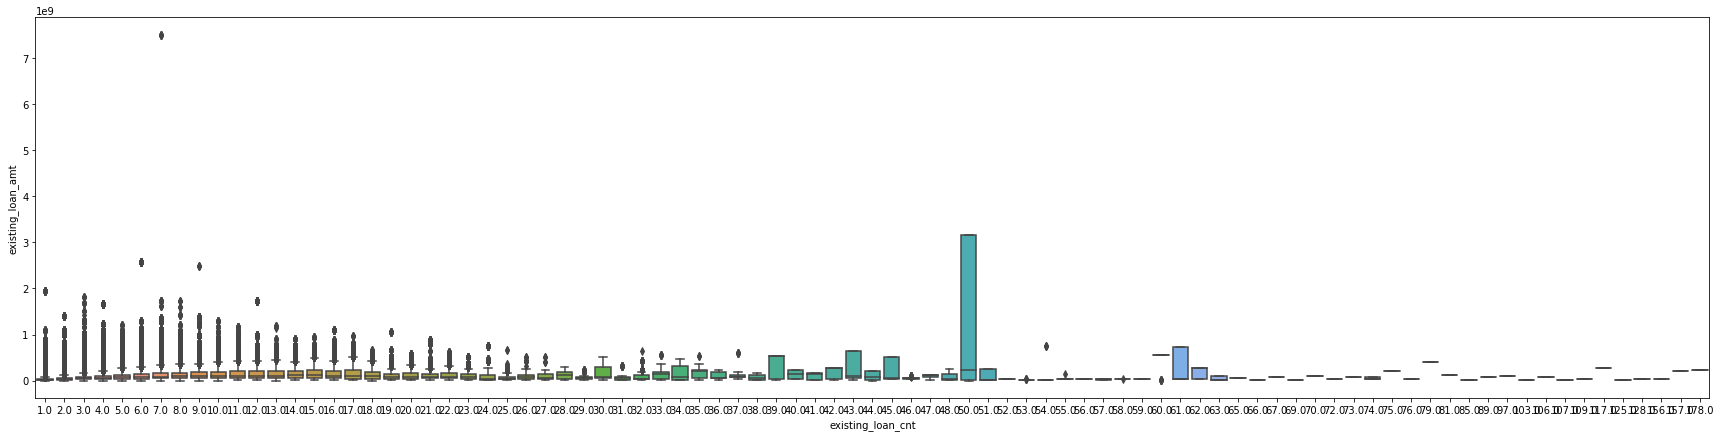

In [ ]:
fig = plt.figure(figsize=(30,7))
sns.boxplot(y='existing_loan_amt', x='existing_loan_cnt', data=train)

In [ ]:
t = train[['user_id','existing_loan_cnt','existing_loan_amt']].drop_duplicates()
  ## 한명이 여러번 대출 신청을 하거나/여러개의 대출상품을 추천 받으면 값에 영향을 주므로 중복제거

In [ ]:
t.groupby(['existing_loan_cnt'])[['existing_loan_amt']].count()


,existing_loan_amt
existing_loan_cnt,
1.0,22756
2.0,26387
3.0,26717
4.0,23497
5.0,19399
...,...
125.0,1
128.0,1
156.0,1


- existing_loan_cnt >= 50

existing_loan_cnt가 50 이상인 것들은 대부분 1명 또는 2명 존재

-> existing_loan_cnt가 50 이상이면 50으로 대체함

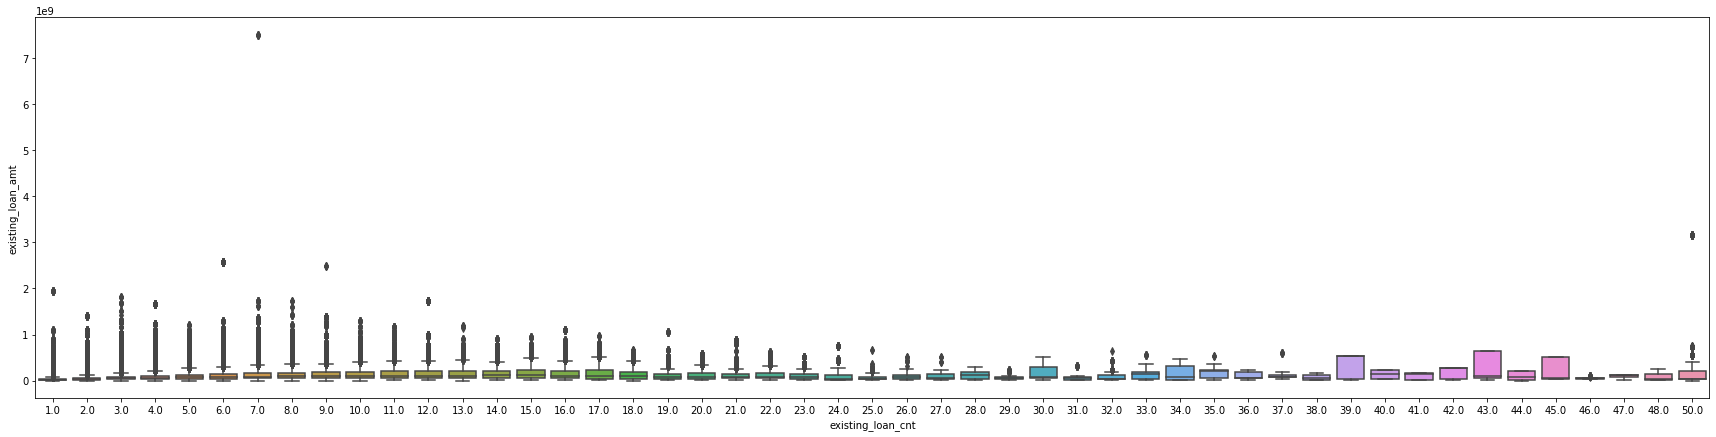

In [ ]:
train.loc[train['existing_loan_cnt'] >= 50, 'existing_loan_cnt'] = 50
fig = plt.figure(figsize=(30,7))
sns.boxplot(y='existing_loan_amt', x='existing_loan_cnt', data=train)

- existing_loan_cnt 당 existing_loan_amt >= 2*99percentile

existing_loan_cnt 당 유저수가 1000명 이상인 것에만 (cnt = 1~13 & 50) 이상치 처리해줌

각 existing_loan_cnt 당 existing_loan_amt가 2*99percentile 이상이면 해당 값으로 대체


In [ ]:
train1 = train.copy()

train1.loc[(train1['existing_loan_cnt'] == 1)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 1]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 1]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 2)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 2]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 2]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 3)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 3]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 3]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 4)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 4]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 4]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 5)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 5]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 5]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 6)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 6]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 6]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 7)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 7]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 7]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 8)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 8]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 8]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 9)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 9]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 9]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 10)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 10]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 10]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 11)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 11]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 11]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 12)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 12]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 12]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 13)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 13]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 13]['existing_loan_amt'], 99))
train1.loc[(train1['existing_loan_cnt'] == 50)&(train1['existing_loan_amt']>(2*np.percentile(train1[train1['existing_loan_cnt'] == 50]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(train1[train1['existing_loan_cnt'] == 50]['existing_loan_amt'], 99))

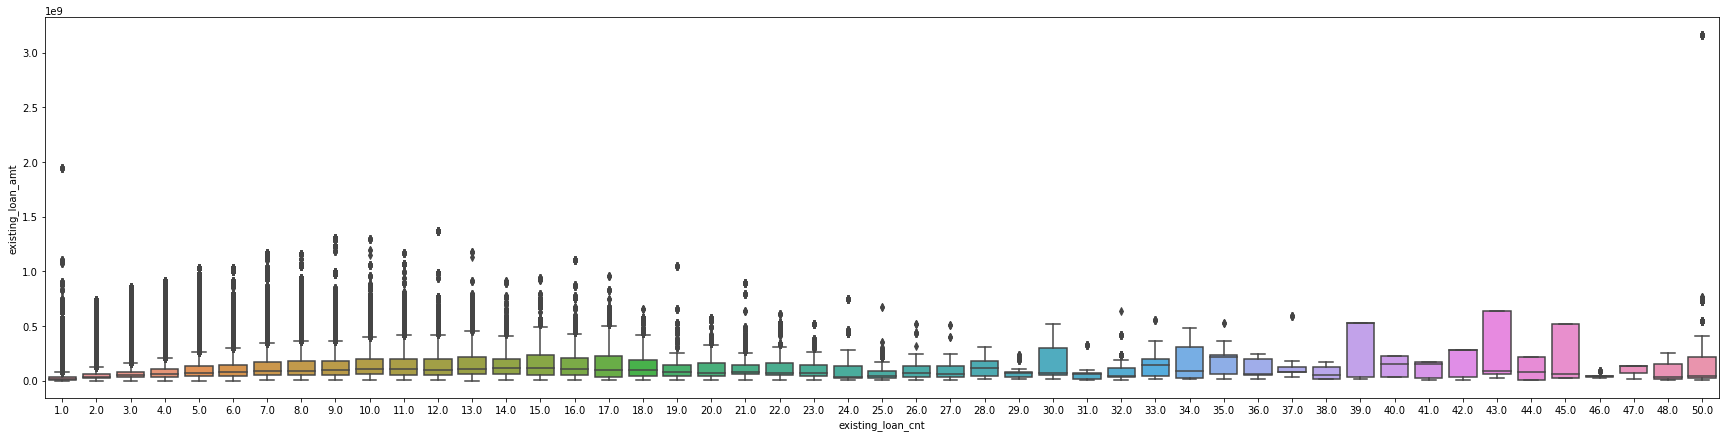

In [ ]:
## 이상치 처리 후 분포
fig = plt.figure(figsize=(30,7))
sns.boxplot(y='existing_loan_amt', x='existing_loan_cnt', data=train1)

In [ ]:
train = train1.copy()
train1= np.NaN

#### (2) 결측치 처리

In [ ]:
# 전부 0으로 대체
train.loc[train['existing_loan_cnt'] != train['existing_loan_cnt'], 'existing_loan_cnt'] = 0
train.loc[train['existing_loan_amt'] != train['existing_loan_amt'], 'existing_loan_amt'] = 0

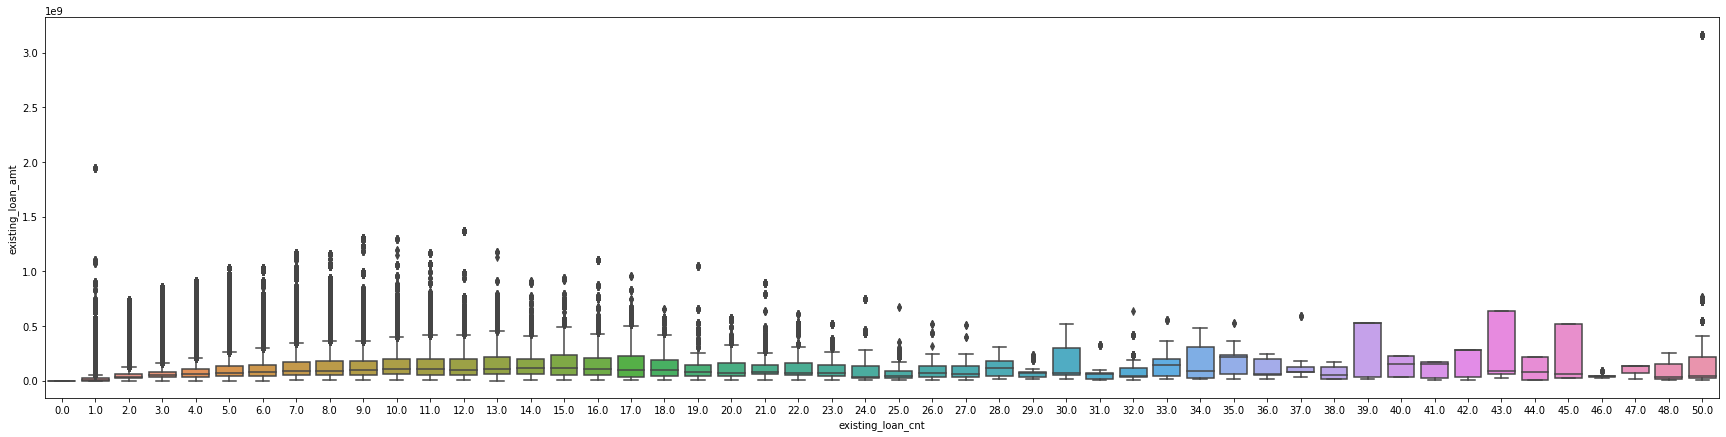

In [ ]:
fig = plt.figure(figsize=(30,7))
sns.boxplot(y='existing_loan_amt', x='existing_loan_cnt', data=train)

### 2) yealy_income

#### (1) 이상치 처리
어플 상 10억 이상은 입력 불가

In [ ]:
income_10 = train[train['yearly_income']>1000000000] # 10억 초과인 사람들 (반올림하면 10억까지 가능함)
income_10

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
18619,154711,2022-05-11 20:35:43,38,16,10000000.0,14.9,0.0,130342,1975.0,0.0,...,EARNEDINCOME,201209.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
18621,154711,2022-05-11 20:35:46,19,26,44000000.0,7.9,0.0,130342,1975.0,0.0,...,EARNEDINCOME,201209.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
18623,154711,2022-05-11 20:35:35,21,196,3000000.0,7.5,0.0,130342,1975.0,0.0,...,EARNEDINCOME,201209.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
18625,154711,2022-05-11 20:35:34,13,262,3000000.0,17.5,0.0,130342,1975.0,0.0,...,EARNEDINCOME,201209.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
18626,154711,2022-05-11 20:35:34,55,12,2000000.0,12.6,0.0,130342,1975.0,0.0,...,EARNEDINCOME,201209.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10259032,174785,2022-05-16 15:59:54,34,215,32000000.0,11.9,0.0,118401,1972.0,0.0,...,EARNEDINCOME,201301.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
10259033,174785,2022-05-16 15:59:53,19,231,50000000.0,13.3,0.0,118401,1972.0,0.0,...,EARNEDINCOME,201301.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
10259034,174385,2022-05-16 15:13:45,55,12,22000000.0,12.6,0.0,118401,1972.0,0.0,...,EARNEDINCOME,201301.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0
10259035,174785,2022-05-16 15:59:54,14,128,8000000.0,6.9,0.0,118401,1972.0,0.0,...,EARNEDINCOME,201301.0,정규직,자가,20000000.0,생활비,0.0,NaN,0.0,0.0


In [ ]:
# yearly_income(연소득)이 10억 이하인 행
income = train[train['yearly_income'] <= 1000000000] # 10억 이하인 사람들
income

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,2157865,2022-05-09 08:44:59,54,235,20000000.0,16.5,1.0,346970,1970.0,1.0,...,EARNEDINCOME,201312.0,정규직,자가,10000000.0,생활비,0.0,NaN,12.0,162000000.0
1,576643,2022-05-09 10:54:53,54,235,11000000.0,16.5,0.0,545882,1977.0,1.0,...,EARNEDINCOME,201908.0,정규직,전월세,20000000.0,생활비,0.0,NaN,7.0,106000000.0
2,576643,2022-05-09 10:54:53,11,118,3000000.0,20.0,0.0,545882,1977.0,1.0,...,EARNEDINCOME,201908.0,정규직,전월세,20000000.0,생활비,0.0,NaN,7.0,106000000.0
3,2136706,2022-05-09 10:41:06,42,216,10000000.0,13.5,0.0,558819,1983.0,1.0,...,EARNEDINCOME,201203.0,정규직,전월세,80000000.0,대환대출,0.0,NaN,2.0,58000000.0
4,2136706,2022-05-09 10:41:07,25,169,22000000.0,15.9,0.0,558819,1983.0,1.0,...,EARNEDINCOME,201203.0,정규직,전월세,80000000.0,대환대출,0.0,NaN,2.0,58000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263781,1969227,2022-05-16 14:42:58,2,7,30000000.0,13.6,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0
10263782,1969227,2022-05-16 14:42:57,33,110,9000000.0,14.4,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0
10263783,1969227,2022-05-16 14:42:56,50,142,3000000.0,11.2,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0
10263784,1969227,2022-05-16 14:43:18,22,100,4000000.0,15.3,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0


In [ ]:
a = income.groupby(['income_type','employment_type'])['yearly_income'].agg(**{
    'most_common_value':lambda x:x.mode()
}, count = 'count').reset_index()
a2 = income.groupby(['income_type','employment_type'])['yearly_income'].median().reset_index()

In [ ]:
# income_type(근로형태)별 + employment_type(고용형태)별 yearly_income(연소득) 최빈값, 개수, 중앙값 확인
aa2 = pd.merge(a, a2, on = ['income_type','employment_type'], how = 'right')
aa2

,income_type,employment_type,most_common_value,count,yearly_income
0,EARNEDINCOME,계약직,30000000.0,750965,30000000.0
1,EARNEDINCOME,기타,30000000.0,67012,30000000.0
2,EARNEDINCOME,일용직,40000000.0,89900,40000000.0
3,EARNEDINCOME,정규직,30000000.0,7797457,38000000.0
4,EARNEDINCOME2,계약직,30000000.0,117176,28000000.0
5,EARNEDINCOME2,기타,30000000.0,64299,30000000.0
6,EARNEDINCOME2,일용직,30000000.0,39372,30000000.0
7,EARNEDINCOME2,정규직,30000000.0,249884,30000000.0
8,FREELANCER,계약직,24000000.0,4161,30000000.0
9,FREELANCER,기타,30000000.0,237401,30000000.0


income_type(근로형태) 및 employment_type(고용형태)별로 중앙값 대체

In [ ]:
train.loc[income_10.index, 'yearly_income'] = np.NaN
len(train[train['yearly_income'].isnull()])  # 이상치들이 NaN으로 잘 대체됨을 확인

8753

In [ ]:
# yearly_income 10억 초과인 값 -> 같은 근로형태 및 고용형태별 중앙값으로 대체
train['yearly_income'] = train['yearly_income'].fillna(train.groupby(['income_type','employment_type'])['yearly_income'].transform('median'))

In [ ]:
train['yearly_income'].isnull().sum()

0

### 3) loan_rate


#### (1) 이상치 처리

In [ ]:
train.loc[train['loan_rate'] == 1.5]

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
1383916,1704768,2022-03-15 10:35:15,56,5,2000000.0,1.5,1.0,818859,1988.0,0.0,...,EARNEDINCOME,202012.0,정규직,기타가족소유,5000000.0,생활비,NaN,NaN,3.0,41000000.0
5449884,617783,2022-03-15 11:39:29,56,5,2000000.0,1.5,0.0,65031,1986.0,0.0,...,EARNEDINCOME,202010.0,정규직,전월세,45000000.0,LIVING,NaN,NaN,3.0,53000000.0
5516561,1921905,2022-03-15 11:01:25,56,5,2000000.0,1.5,1.0,480406,1999.0,1.0,...,EARNEDINCOME,202201.0,정규직,기타가족소유,5000000.0,생활비,NaN,NaN,0.0,0.0
8357946,1221861,2022-03-15 10:33:07,56,5,2000000.0,1.5,1.0,85296,1991.0,0.0,...,PRACTITIONER,201412.0,정규직,전월세,2000000.0,생활비,NaN,NaN,4.0,40000000.0
8431607,1999086,2022-03-15 11:10:38,56,5,2000000.0,1.5,1.0,334661,1994.0,1.0,...,EARNEDINCOME,202002.0,정규직,전월세,3000000.0,생활비,NaN,NaN,1.0,6000000.0


In [ ]:
train[train['loan_rate'] == 1.5]['product_id'].unique()
 # 전부 product_id = 5

array([5])

In [ ]:
sorted(train[train['product_id']==5]['loan_rate'].unique())
  # 1.5 => 데이터 오류로 판단

[1.5,
 7.4,
 8.9,
 11.1,
 11.9,
 12.6,
 13.2,
 13.6,
 13.7,
 14.2,
 14.6,
 14.7,
 14.8,
 15.2,
 15.9,
 16.1,
 16.3,
 16.6,
 16.8,
 17.4,
 17.6,
 18.5,
 19.2,
 19.5,
 19.9]

In [ ]:
# loan_rate = 1.5 -> 15로 대체
train.loc[train['loan_rate'] == 1.5, 'loan_rate'] = 15
len(train[train['loan_rate'] == 1.5])

0

### 4) loan_limit

#### (1) 이상치 처리
0/2.5억 초과/100억

-> 같은 상품/rate 의 loan_limit 중앙값으로 대체

In [ ]:
loanlimit_outlier = train[(train['loan_limit'] == 0) | (train['loan_limit'] > 250000000)]
loanlimit_outlier

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
214,1835670,2022-05-09 15:24:12,20,131,0.0,6.9,0.0,178632,1969.0,1.0,...,EARNEDINCOME,200403.0,정규직,자가,50000000.0,생활비,0.0,NaN,4.0,849000000.0
1294,847844,2022-05-09 12:43:53,14,197,0.0,18.9,0.0,310836,1976.0,0.0,...,EARNEDINCOME,202101.0,정규직,전월세,5000000.0,생활비,0.0,NaN,11.0,69000000.0
3675,1124081,2022-05-09 10:44:40,14,197,0.0,18.8,0.0,667110,1991.0,1.0,...,EARNEDINCOME,202107.0,정규직,기타가족소유,2000000.0,생활비,0.0,NaN,4.0,29000000.0
8016,415899,2022-05-09 11:26:04,31,244,267000000.0,9.5,1.0,720368,1975.0,1.0,...,PRIVATEBUSINESS,201307.0,정규직,자가,70000000.0,생활비,NaN,NaN,0.0,0.0
8752,448540,2022-05-09 08:42:16,12,35,0.0,18.7,0.0,357925,1963.0,1.0,...,EARNEDINCOME,202202.0,계약직,전월세,20000000.0,대환대출,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244980,344885,2022-05-09 12:54:45,14,197,0.0,18.9,0.0,674867,1980.0,1.0,...,EARNEDINCOME,202102.0,정규직,자가,70000000.0,대환대출,0.0,NaN,4.0,22000000.0
10245098,344935,2022-05-09 10:45:46,12,35,0.0,18.9,0.0,294397,1979.0,0.0,...,EARNEDINCOME,202106.0,정규직,전월세,30000000.0,생활비,0.0,NaN,10.0,35000000.0
10249307,1306074,2022-05-09 14:46:56,32,56,0.0,13.9,0.0,64877,1982.0,1.0,...,EARNEDINCOME,201404.0,정규직,자가,50000000.0,생활비,0.0,NaN,1.0,0.0
10249768,1484594,2022-05-09 09:39:19,5,194,0.0,14.9,0.0,11147,1981.0,0.0,...,EARNEDINCOME,200403.0,정규직,기타가족소유,10000000.0,생활비,0.0,0.0,5.0,99000000.0


In [ ]:
loanlimit =  train[train['loan_limit']!=0]
loanlimit

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,2157865,2022-05-09 08:44:59,54,235,20000000.0,16.5,1.0,346970,1970.0,1.0,...,EARNEDINCOME,201312.0,정규직,자가,10000000.0,생활비,0.0,NaN,12.0,162000000.0
1,576643,2022-05-09 10:54:53,54,235,11000000.0,16.5,0.0,545882,1977.0,1.0,...,EARNEDINCOME,201908.0,정규직,전월세,20000000.0,생활비,0.0,NaN,7.0,106000000.0
2,576643,2022-05-09 10:54:53,11,118,3000000.0,20.0,0.0,545882,1977.0,1.0,...,EARNEDINCOME,201908.0,정규직,전월세,20000000.0,생활비,0.0,NaN,7.0,106000000.0
3,2136706,2022-05-09 10:41:06,42,216,10000000.0,13.5,0.0,558819,1983.0,1.0,...,EARNEDINCOME,201203.0,정규직,전월세,80000000.0,대환대출,0.0,NaN,2.0,58000000.0
4,2136706,2022-05-09 10:41:07,25,169,22000000.0,15.9,0.0,558819,1983.0,1.0,...,EARNEDINCOME,201203.0,정규직,전월세,80000000.0,대환대출,0.0,NaN,2.0,58000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263781,1969227,2022-05-16 14:42:58,2,7,30000000.0,13.6,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0
10263782,1969227,2022-05-16 14:42:57,33,110,9000000.0,14.4,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0
10263783,1969227,2022-05-16 14:42:56,50,142,3000000.0,11.2,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0
10263784,1969227,2022-05-16 14:43:18,22,100,4000000.0,15.3,0.0,109899,1977.0,1.0,...,EARNEDINCOME,202108.0,정규직,자가,20000000.0,대환대출,0.0,NaN,9.0,107000000.0


In [ ]:
loanlimit2 = loanlimit.drop_duplicates(['product_id','loan_rate','user_id'])
a = loanlimit2.groupby(['product_id','loan_rate'])['loan_limit'].agg(**{
    'most_common_value':lambda x:x.mode()
}, count = 'count').reset_index()
a2 = loanlimit2.groupby(['product_id','loan_rate'])['loan_limit'].median().reset_index()

In [ ]:
# product_id별 + loan_rate(승인금리)별 최빈값, 개수, loan_limit(승인금리)의 중앙값 확인
pd.options.display.max_rows = 4494
aa2 = pd.merge(a, a2, on = ['product_id','loan_rate'], how = 'right')
aa2.head(4494)

,product_id,loan_rate,most_common_value,count,loan_limit
0,1,4.8,50000000.0,109,50000000.0
1,1,8.9,3000000.0,13501,36000000.0
2,1,9.9,3000000.0,9515,23000000.0
3,1,10.9,3000000.0,8609,12000000.0
4,1,11.9,3000000.0,4663,9000000.0
5,1,12.9,3000000.0,1570,3000000.0
6,1,13.9,5000000.0,1085,9000000.0
7,1,15.4,20000000.0,1722,18000000.0
8,1,16.9,10000000.0,383,10000000.0
9,5,7.4,"[2000000.0, 45000000.0]",2,23500000.0


In [ ]:
train.loc[loanlimit_outlier.index, 'loan_limit'] = np.NaN
len(train[train['loan_limit'].isnull()])  # 이상치들이 NaN으로 잘 대체됨을 확인

5856

In [ ]:
# loan_limit 이상치 -> 같은 상품 및 승인금리별 중앙값으로 대체
train['loan_limit'] = train['loan_limit'].fillna(train.groupby(['product_id','loan_rate'])['loan_limit'].transform('median'))

In [ ]:
## 금리가 존재하지 않는 경우가 있음
# 모두 product_id == 244
train[train['loan_limit'].isnull()]['loan_rate'].unique()
  # 승인금리는 7.2, 7.5, 7.8, 9.0, 9.6 (총 5개)

array([7.5, 7.8, 7.2, 9. , 9.6])

In [ ]:
product_244 = train[train['product_id'] == 244]
product_244[product_244['loan_rate'] == 7.5]

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
1191528,2082956,2022-03-29 10:59:06,31,244,NaN,7.5,0.0,528957,1999.0,0.0,...,EARNEDINCOME,202005.0,정규직,기타가족소유,5000000.0,생활비,NaN,NaN,6.0,36000000.0
1191529,1979812,2022-03-29 11:03:44,31,244,NaN,7.5,0.0,528957,1999.0,0.0,...,EARNEDINCOME,202005.0,정규직,기타가족소유,5000000.0,생활비,NaN,NaN,6.0,36000000.0
1800938,1933728,2022-03-29 07:17:28,31,244,NaN,7.5,0.0,495040,1983.0,1.0,...,EARNEDINCOME,201301.0,정규직,자가,20000000.0,생활비,NaN,NaN,4.0,89000000.0
2357891,2036851,2022-03-29 12:45:39,31,244,NaN,7.5,0.0,115740,2000.0,0.0,...,EARNEDINCOME,202106.0,정규직,기타가족소유,30000000.0,생활비,NaN,NaN,0.0,0.0
2357892,2029533,2022-03-29 12:21:30,31,244,NaN,7.5,0.0,115740,2000.0,0.0,...,EARNEDINCOME,202106.0,정규직,기타가족소유,15000000.0,대환대출,NaN,NaN,0.0,0.0
2377980,1710000,2022-03-29 13:05:08,31,244,NaN,7.5,0.0,370968,1989.0,1.0,...,EARNEDINCOME,202202.0,정규직,기타가족소유,10000000.0,대환대출,NaN,NaN,7.0,28000000.0
2379367,1834452,2022-03-29 14:48:38,31,244,NaN,7.5,0.0,220331,1993.0,1.0,...,EARNEDINCOME,202106.0,정규직,기타가족소유,30000000.0,대환대출,NaN,NaN,3.0,41000000.0
2392012,1571717,2022-03-29 11:40:28,31,244,NaN,7.5,0.0,813537,1982.0,1.0,...,EARNEDINCOME,201203.0,정규직,자가,1000000.0,생활비,NaN,NaN,3.0,85000000.0
5148701,1112562,2022-03-08 08:17:32,31,244,NaN,7.5,0.0,49918,1977.0,0.0,...,EARNEDINCOME,200701.0,정규직,자가,10000000.0,사업자금,NaN,NaN,3.0,293000000.0
5686068,414985,2022-03-24 19:47:47,31,244,NaN,7.5,0.0,32395,1975.0,1.0,...,PRIVATEBUSINESS,200702.0,정규직,자가,100000000.0,생활비,NaN,NaN,4.0,912000000.0


위 아래 승인한도를 포함하여 중앙값 대체

예를 들어, 승인한도가 7.5인 행의 승인금리를 대체하고 싶다면, 승인한도가 7.4, 7.6인 행의 승인금리 중앙값으로 대체

In [ ]:
# product_id == 244 & loan_rate == 7.2
idx = train[(train['product_id'] == 244) & (train['loan_rate'] == 7.2)].index
value = product_244[(product_244['loan_rate'] == 7.1) | (product_244['loan_rate'] == 7.3)]['loan_limit'].median()
train.loc[idx, 'loan_limit'] = value

In [ ]:
# product_id == 244 & loan_rate == 7.5
idx = train[(train['product_id'] == 244) & (train['loan_rate'] == 7.5)].index
value = product_244[(product_244['loan_rate'] == 7.4) | (product_244['loan_rate'] == 7.6)]['loan_limit'].median()
train.loc[idx, 'loan_limit'] = value

In [ ]:
# product_id == 244 & loan_rate == 7.8
idx = train[(train['product_id'] == 244) & (train['loan_rate'] == 7.8)].index
value = product_244[(product_244['loan_rate'] == 7.7) | (product_244['loan_rate'] == 7.9)]['loan_limit'].median()
train.loc[idx, 'loan_limit'] = value

In [ ]:
# product_id == 244 & loan_rate == 9.0
idx = train[(train['product_id'] == 244) & (train['loan_rate'] == 9.0)].index
value = product_244[(product_244['loan_rate'] == 8.9) | (product_244['loan_rate'] == 9.1)]['loan_limit'].median()
train.loc[idx, 'loan_limit'] = value

In [ ]:
# product_id == 244 & loan_rate == 9.6
idx = train[(train['product_id'] == 244) & (train['loan_rate'] == 9.6)].index
value = product_244[(product_244['loan_rate'] == 9.5) | (product_244['loan_rate'] == 9.7)]['loan_limit'].median()
train.loc[idx, 'loan_limit'] = value

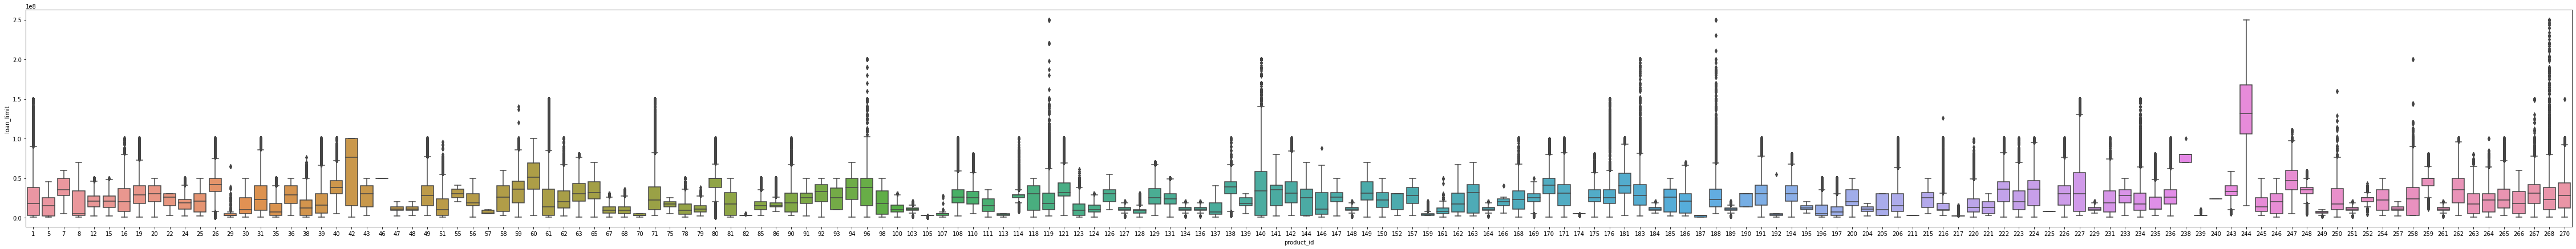

In [ ]:
fig = plt.figure(figsize=(80,7))
sns.boxplot(y='loan_limit', x='product_id', data=train)

### 5) desired_amount


#### (1) 이상치 처리
0 => 25만원 대체

In [ ]:
train['desired_amount']= np.where(train['desired_amount']==0, 250000, train['desired_amount'])
train[train['desired_amount']==0]

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt


### 6) company_enter_month

#### (1) 결측치 처리
- oterincome인 경우, 입력 불필요한 값 &rarr; 2023년으로 대체
- 대체되지 않은 4명
    - 개인사업자, 직장가입자 &rarr; 같은 나이 고객에 대해서 [직업별 입사 만나이 중앙값 + 생년월일]로 대체 

In [ ]:
## oterincome인 경우, 입력 불필요한 값 → 2023년01월로 대체
train['company_enter_month'] = np.where((train['income_type']=="OTHERINCOME")&(train['company_enter_month'].isna()), 202301, train['company_enter_month'])

In [ ]:
train[(train['income_type']=="OTHERINCOME")&(train['company_enter_month'].isna())]

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt


In [ ]:
cem55 = train.query('company_enter_month.isna()', engine='python')
cem55

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
842380,1026844,2022-04-08 15:12:09,10,149,14000000.0,15.6,0.0,174784,1998.0,1.0,...,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,0.0,0.0
842381,1026844,2022-04-08 15:12:11,56,5,2000000.0,19.9,0.0,174784,1998.0,1.0,...,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,0.0,0.0
842382,1026844,2022-04-08 15:12:10,25,169,25000000.0,19.9,0.0,174784,1998.0,1.0,...,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,0.0,0.0
842383,1026844,2022-04-08 15:12:10,32,56,10000000.0,17.7,0.0,174784,1998.0,1.0,...,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,0.0,0.0
842384,1026844,2022-04-08 15:12:10,6,36,17000000.0,18.4,0.0,174784,1998.0,1.0,...,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,0.0,0.0
842385,1026844,2022-04-08 15:12:10,33,110,14000000.0,14.4,0.0,174784,1998.0,1.0,...,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,0.0,0.0
842386,1026844,2022-04-08 15:12:09,10,65,14000000.0,15.6,0.0,174784,1998.0,1.0,...,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,0.0,0.0
1670982,1024494,2022-05-16 15:28:54,1,61,50000000.0,9.4,0.0,418233,1985.0,0.0,...,PRIVATEBUSINESS,NaN,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0
1670983,1024494,2022-05-16 15:28:54,30,85,10000000.0,13.8,0.0,418233,1985.0,0.0,...,PRIVATEBUSINESS,NaN,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0
1670984,1024494,2022-05-16 15:28:54,42,216,10000000.0,14.3,0.0,418233,1985.0,0.0,...,PRIVATEBUSINESS,NaN,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0


In [ ]:
cem55['user_id'].nunique()    # 4명에 대한 입사년월 채워야함 - EARNEDINCOME  PRIVATEBUSINESS  EARNEDINCOME  EARNEDINCOME

4

In [ ]:
EARNEDINCOME = train.query("income_type in ['EARNEDINCOME', 'PRIVATEBUSINESS']", engine='python')    # 결측치 채울 income_type만 불러오기
EARNEDINCOME = EARNEDINCOME.astype({'company_enter_month':'str'})                    # float -> string
EARNEDINCOME = EARNEDINCOME[['user_id','income_type','birth_year','company_enter_month']]
EARNEDINCOME = EARNEDINCOME.dropna()
EARNEDINCOME.drop_duplicates(inplace=True)
EARNEDINCOME['company_enter_year'] = EARNEDINCOME['company_enter_month'].str[:4]     # 입사년월에서 year만 추출

EARNEDINCOME = EARNEDINCOME.astype({'company_enter_year':'float'})                   # string -> float
EARNEDINCOME['company_enter_age'] = EARNEDINCOME['company_enter_year'] - EARNEDINCOME['birth_year']    # 입사 만 나이

In [ ]:
print(EARNEDINCOME.query('income_type=="EARNEDINCOME" & birth_year==1998', engine='python')['company_enter_age'].describe())  # 23
print('\n')
print(EARNEDINCOME.query('income_type=="EARNEDINCOME" & birth_year==1991', engine='python')['company_enter_age'].describe())  # 29
print('\n')
print(EARNEDINCOME.query('income_type=="EARNEDINCOME" & birth_year==1980', engine='python')['company_enter_age'].describe())  # 39
print('\n')
print(EARNEDINCOME.query('income_type=="PRIVATEBUSINESS" & birth_year==1985', engine='python')['company_enter_age'].describe())  #34

count    2975.000000
mean       22.820840
std         1.362569
min         0.000000
25%        23.000000
50%        23.000000
75%        24.000000
max        24.000000
Name: company_enter_age, dtype: float64


count    6670.000000
mean       28.486807
std         2.415597
min         0.000000
25%        27.000000
50%        29.000000
75%        30.000000
max        31.000000
Name: company_enter_age, dtype: float64


count    6300.000000
mean       36.739206
std         5.550594
min         0.000000
25%        34.000000
50%        39.000000
75%        41.000000
max        42.000000
Name: company_enter_age, dtype: float64


count    982.000000
mean      33.727088
std        2.798511
min       17.000000
25%       33.000000
50%       34.000000
75%       36.000000
max       37.000000
Name: company_enter_age, dtype: float64


In [ ]:
## 만나이의 중간값 사용, 입사년월 대체
train['company_enter_month']= np.where(train['user_id']==174784, 202101, train['company_enter_month'])
train['company_enter_month']= np.where(train['user_id']==776609, 202001, train['company_enter_month'])
train['company_enter_month']= np.where(train['user_id']==861913, 201901, train['company_enter_month'])
train['company_enter_month']= np.where(train['user_id']==418233, 201901, train['company_enter_month'])

#### (2) 이상치 처리
- 생년월일보다 입사년도가 오래되거나 같은 행 (709행) 
    - 같은 나이 고객에 대해서 [직업별 입사 만나이 중앙값 + 생년월일]로 대체 

In [ ]:
## 생년월일보다 입사년도가 오래되거나 같은 행
train = train.astype({'company_enter_month':'str'})                       # float -> str
train['company_enter_year'] = train['company_enter_month'].str[:4]        # 입사년월에서 year만 추출
train = train.astype({'company_enter_year':'float'})                      # str -> float
len(train.query('birth_year>=company_enter_year'))                        # 총 709 행

709

In [ ]:
## 생년월일보다 입사년도가 오래되거나 같은 행 income_type 종류 확인
train.query('birth_year>=company_enter_year')['income_type'].value_counts()

EARNEDINCOME       537
PRIVATEBUSINESS     82
EARNEDINCOME2       38
FREELANCER          37
PRACTITIONER        15
Name: income_type, dtype: int64

In [ ]:
age = train.query("income_type in ['EARNEDINCOME', 'PRIVATEBUSINESS','EARNEDINCOME2','FREELANCER','PRACTITIONER']")
age = age.astype({'company_enter_month':'str'})                                      # float -> string
age = age[['user_id','income_type','birth_year','company_enter_month']]
age.drop_duplicates(inplace=True)
age['company_enter_year'] = age['company_enter_month'].str[:4]                       # 입사년월에서 year만 추출
age = age.astype({'company_enter_year':'float'})                                     # string -> float
age['company_enter_age'] = age['company_enter_year'] - age['birth_year']             # 입사 만나이 
age.head()                                                                           # 각 행에 대한 입사 만나이 확인

,user_id,income_type,birth_year,company_enter_month,company_enter_year,company_enter_age
0,346970,EARNEDINCOME,1970.0,201312.0,2013.0,43.0
1,545882,EARNEDINCOME,1977.0,201908.0,2019.0,42.0
3,558819,EARNEDINCOME,1983.0,201203.0,2012.0,29.0
43,341662,EARNEDINCOME,1991.0,202108.0,2021.0,30.0
95,17957,EARNEDINCOME,1985.0,201508.0,2015.0,30.0


In [ ]:
## 생년월일보다 입사년도가 오래되거나 같은 행 입사 만나이 확인 -> 이상치 대체 필요함
age1 = age.query('birth_year>=company_enter_year')[['user_id','income_type','birth_year','company_enter_age']].drop_duplicates().sort_values(['user_id','birth_year'])
age1

,user_id,income_type,birth_year,company_enter_age
3348581,4194,EARNEDINCOME,1991.0,0.0
2098916,9435,EARNEDINCOME,2001.0,0.0
1751154,27025,EARNEDINCOME,1969.0,-26.0
5587969,27284,EARNEDINCOME,1957.0,-41.0
8558809,40784,FREELANCER,1985.0,0.0
10239539,59649,PRIVATEBUSINESS,1951.0,0.0
4255265,92946,EARNEDINCOME,1969.0,-50.0
417408,119889,EARNEDINCOME,1998.0,0.0
8473456,137269,EARNEDINCOME,1989.0,0.0
7740133,140739,EARNEDINCOME,1996.0,0.0


In [ ]:
## 생년월일보다 입사년도가 오래되지 않은 행 (정상적인 행)에 대한 income_type별 입사 나이 중앙값
age2 = age.query('birth_year<company_enter_year').groupby(['income_type','birth_year']).agg(median = ('company_enter_age','median'))
age2

median
income_type     birth_year        
EARNEDINCOME    1937.0        79.0
                1938.0        80.5
                1942.0        78.5
                1943.0        74.0
                1944.0        72.5
                1945.0        74.0
                1946.0        75.0
                1947.0        73.5
                1948.0        72.0
                1949.0        71.0
                1950.0        69.0
                1951.0        69.0
                1952.0        68.0
                1953.0        67.0
                1954.0        66.0
                1955.0        65.0
                1956.0        64.0
                1957.0        63.0
                1958.0        62.0
                1959.0        61.0
                1960.0        60.0
                1961.0        59.0
                1962.0        57.0
                1963.0        56.0
                1964.0        55.0
                1965.0        54.0
                1966.0        53.0
                1967.0        52.0
                1968.0        51.0
                1969.0        50.0
                1970.0        49.0
                1971.0        48.0
                1972.0        47.0
                1973.0        46.0
                1974.0        45.0
                1975.0        44.0
                1976.0        43.0
                1977.0        42.0
                1978.0        41.0
                1979.0        40.0
                1980.0        39.0
                1981.0        38.0
                1982.0        37.0
                1983.0        36.0
                1984.0        35.0
                1985.0        34.0
                1986.0        33.0
                1987.0        33.0
                1988.0        32.0
                1989.0        31.0
                1990.0        30.0
                1991.0        29.0
                1992.0        29.0
                1993.0        28.0
                1994.0        27.0
                1995.0        26.0
                1996.0        25.0
                1997.0        24.0
                1998.0        23.0
                1999.0        22.0
                2000.0        21.0
                2001.0        20.0
                2002.0        19.0
                2003.0        19.0
EARNEDINCOME2   1935.0        83.0
                1936.0        84.0
                1939.0        82.0
                1940.0        81.0
                1941.0        77.0
                1942.0        79.0
                1943.0        75.0
                1944.0        77.0
                1945.0        76.0
                1946.0        73.5
                1947.0        74.0
                1948.0        72.5
                1949.0        71.0
                1950.0        70.0
                1951.0        69.0
                1952.0        68.0
                1953.0        68.0
                1954.0        67.0
                1955.0        66.0
                1956.0        64.0
                1957.0        63.0
                1958.0        62.0
                1959.0        62.0
                1960.0        61.0
                1961.0        59.0
                1962.0        58.0
                1963.0        57.0
                1964.0        57.0
                1965.0        55.0
                1966.0        54.0
                1967.0        53.0
                1968.0        52.0
                1969.0        51.0
                1970.0        50.0
                1971.0        49.0
                1972.0        48.0
                1973.0        47.0
                1974.0        46.0
                1975.0        45.0
                1976.0        44.0
                1977.0        43.0
                1978.0        42.0
                1979.0        42.0
                1980.0        40.0
                1981.0        40.0
                1982.0        39.0
                1983.0        38.0
                1984.0        37.0
                1985.0        36.0
   

In [ ]:
## 같은 나이 고객에 대해서 [직업별 입사 만나이 중앙값 + 생년월일]로 이상치 대체
## 월은 임의로 1월로 설정
age3 = pd.merge(age1, age2, how='left',on=['income_type','birth_year'])
age3['birth+med']=age3['birth_year']+age3['median']
age3 = age3.astype({'birth+med':'str'})
age3['month']='01'
age3['birth+med'] = age3['birth+med'].str[:4]
age3['company_enter_month'] = age3['birth+med'] + age3['month']

missing =pd.merge(age1, age3, how='left',on=['user_id','income_type','birth_year','company_enter_age'])[['user_id','income_type','company_enter_month']]

In [ ]:
train= pd.merge(train, missing, how='left', on=['user_id','income_type'])
train['company_enter_year2'] = np.where(train['company_enter_month_y'].isna(), train['company_enter_month_x'] ,train['company_enter_month_y'])
train = train.astype({'company_enter_year2':'float'})

In [ ]:
## 생년월일보다 입사년월이 오래되거나 같은 행 있는지 확인 -> 없음
train.query('company_enter_year2 <= birth_year')

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,company_enter_year,company_enter_month_y,company_enter_year2


In [ ]:
## 이상치 처리 완료 데이터 정리
train.drop(columns=['company_enter_month_x','company_enter_year','company_enter_month_y'], inplace=True)
train.rename(columns={'company_enter_year2':'company_enter_month'}, inplace=True)

### 7) birth_year/gender 
변수 제거


In [ ]:
train.drop(columns=['birth_year', 'gender'], inplace=True)

### 8) personal_rehabilitation


#### (1) 이상치 처리

개인회생자가 아닌데, 개인회생자 납입 완료가 된 행 -> 개인회생자여부를 1로 대체

In [ ]:
idx = train[(train['personal_rehabilitation_yn'] == 0) & (train['personal_rehabilitation_complete_yn'] == 1)].index
train.loc[idx, 'personal_rehabilitation_yn'] = 1

train[(train['personal_rehabilitation_yn'] == 0) & (train['personal_rehabilitation_complete_yn'] == 1)]

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,insert_time,credit_score,...,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,company_enter_month


#### (2) 결측치 처리

In [ ]:
## personal_rehabilitation_complete_yn = 2(해당사항 없음) 추가
train['personal_rehabilitation_complete_yn'] = np.where(train['personal_rehabilitation_yn']==0,2, train['personal_rehabilitation_complete_yn']) 

In [ ]:
## personal_rehabilitation_yn = 0 대체 후, personal_rehabilitation_complete_yn = 2 (해당사항 없음) 으로 대체
train['personal_rehabilitation_complete_yn'] = np.where((train['product_id'].isin([7, 57, 59, 146, 147, 161, 166, 190, 211, 238, 244])) \
                                                & (train['personal_rehabilitation_yn'].isna())
                                                , 2, train['personal_rehabilitation_complete_yn'])
## personal_rehabilitation_yn = 0 으로 채워야 하는 값 추출 -> 대체 
train['personal_rehabilitation_yn'] = np.where((train['product_id'].isin([7, 57, 59, 146, 147, 161, 166, 190, 211, 238, 244])) \
                                                & (train['personal_rehabilitation_yn'].isna())
                                                , 0, train['personal_rehabilitation_yn'])


#### (3) 파생변수
0: 개인회생자 x

1: 개인회생자 o, 납입 완료 o

2: 개인회생자 x, 납입 완료 x

In [ ]:
# 파생변수
#### personal_rehabilitation
## 개인회생 중 x 
train['personal_rehabilitation'] = np.where(train['personal_rehabilitation_yn']==0,0,np.nan)

## 알 수 없음 - 개인회생 중 x
train['personal_rehabilitation'] = np.where((train['personal_rehabilitation_yn'].isna())
                                            &(train['personal_rehabilitation_complete_yn'].isna()), 0, train['personal_rehabilitation'])

## 개인회생중 o, 개인회생납입완료 o
train['personal_rehabilitation'] = np.where((train['personal_rehabilitation_yn'] ==1)
                                              &(train['personal_rehabilitation_complete_yn'] == 1), 1, train['personal_rehabilitation'])
## 개인회생 중 o, 개인회생납입완료 x
train['personal_rehabilitation'] = np.where((train['personal_rehabilitation_yn'] ==1)
                                              &(train['personal_rehabilitation_complete_yn'] == 0), 2, train['personal_rehabilitation'])

In [ ]:
train.drop(columns=['personal_rehabilitation_yn','personal_rehabilitation_complete_yn'], inplace = True)

### 9) creditscore

#### (1) 결측치 처리

In [ ]:
applied = train.loc[train['is_applied'] == 1]
notapplied = train.loc[train['is_applied'] == 0]

In [ ]:
credit_notna = train[train['credit_score'].notna()]
credit_na = train[train['credit_score'].isnull()]

In [ ]:
print('credit_score 결측치 없는 행:', credit_notna.shape)
print('credit_score 결측치 있는 행:', credit_na.shape)

credit_score 결측치 없는 행: (9020547, 20)
credit_score 결측치 있는 행: (1243239, 20)


- 머신러닝 - 랜덤포레스트

In [ ]:
X = credit_notna[['yearly_income', 'income_type', 'existing_loan_cnt', 'existing_loan_amt', 'personal_rehabilitation']] 
y = credit_notna['credit_score'] 

X = X.astype({'personal_rehabilitation':'category',
              'income_type':'category'})

X = pd.get_dummies(X)

X.head()

,yearly_income,existing_loan_cnt,existing_loan_amt,income_type_EARNEDINCOME,income_type_EARNEDINCOME2,income_type_FREELANCER,income_type_OTHERINCOME,income_type_PRACTITIONER,income_type_PRIVATEBUSINESS,personal_rehabilitation_0.0,personal_rehabilitation_1.0,personal_rehabilitation_2.0
0,32000000.0,12.0,162000000.0,1,0,0,0,0,0,1,0,0
1,72000000.0,7.0,106000000.0,1,0,0,0,0,0,1,0,0
2,72000000.0,7.0,106000000.0,1,0,0,0,0,0,1,0,0
3,39000000.0,2.0,58000000.0,1,0,0,0,0,0,1,0,0
4,39000000.0,2.0,58000000.0,1,0,0,0,0,0,1,0,0


In [ ]:
# train, test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1005)

In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor

# 학습
rf = RandomForestRegressor(random_state = 1005, n_jobs = -1)
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)

In [ ]:
# 평가
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.5292544563242718

In [ ]:
# 예측값 대체하기
credit_na_X = credit_na[['yearly_income', 'income_type', 'existing_loan_cnt', 'existing_loan_amt', 'personal_rehabilitation']]

credit_na_X = credit_na_X.astype({'personal_rehabilitation':'category',
                                  'income_type':'category'})

credit_na_X = pd.get_dummies(credit_na_X)

credit_pred = rf.predict(credit_na_X)
credit_pred

array([950.       , 950.       , 950.       , ..., 838.4780056,
       838.4780056, 838.4780056])

In [ ]:
credit_na['credit_score'] = credit_pred
credit_na['credit_score']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


196         950.000000
197         950.000000
198         950.000000
199         950.000000
200         950.000000
               ...    
10263558    838.478006
10263559    838.478006
10263560    838.478006
10263561    838.478006
10263562    838.478006
Name: credit_score, Length: 1243239, dtype: float64

In [ ]:
credit_na['credit_score'].isnull().sum()

0

In [ ]:
credit_na['credit_score'] = round(credit_na['credit_score'], -1)
credit_na['credit_score']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


196         950.0
197         950.0
198         950.0
199         950.0
200         950.0
            ...  
10263558    840.0
10263559    840.0
10263560    840.0
10263561    840.0
10263562    840.0
Name: credit_score, Length: 1243239, dtype: float64

In [ ]:
# 합치기
train1 = pd.concat([credit_notna, credit_na], axis = 0)

In [ ]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10263786 entries, 0 to 10263562
Data columns (total 20 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   application_id           int64  
 1   loanapply_insert_time    object 
 2   bank_id                  int64  
 3   product_id               int64  
 4   loan_limit               float64
 5   loan_rate                float64
 6   is_applied               float64
 7   user_id                  int64  
 8   insert_time              object 
 9   credit_score             float64
 10  yearly_income            float64
 11  income_type              object 
 12  employment_type          object 
 13  houseown_type            object 
 14  desired_amount           float64
 15  purpose                  object 
 16  existing_loan_cnt        float64
 17  existing_loan_amt        float64
 18  company_enter_month      float64
 19  personal_rehabilitation  float64
dtypes: float64(10), int64(4), object(6)
memory u

In [ ]:
train1.isnull().sum()

application_id             0
loanapply_insert_time      0
bank_id                    0
product_id                 0
loan_limit                 0
loan_rate                  0
is_applied                 0
user_id                    0
insert_time                0
credit_score               0
yearly_income              0
income_type                0
employment_type            0
houseown_type              0
desired_amount             0
purpose                    0
existing_loan_cnt          0
existing_loan_amt          0
company_enter_month        0
personal_rehabilitation    0
dtype: int64

In [ ]:
train = train1.copy()

### 10) test data

- existing_loan_cnt/amt 

In [ ]:
## 이상치 처리 
# 'existing_loan_cnt' >= 50
test.loc[test['existing_loan_cnt'] >= 50, 'existing_loan_cnt'] = 50

# 'existing_loan_amt' > 2*np.percentile
test1 = test.copy()

test1.loc[(test1['existing_loan_cnt'] == 1)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 1]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 1]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 2)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 2]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 2]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 3)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 3]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 3]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 4)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 4]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 4]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 5)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 5]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 5]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 6)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 6]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 6]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 7)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 7]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 7]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 8)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 8]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 8]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 9)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 9]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 9]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 10)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 10]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 10]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 11)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 11]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 11]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 12)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 12]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 12]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 13)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 13]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 13]['existing_loan_amt'], 99))
test1.loc[(test1['existing_loan_cnt'] == 50)&(test1['existing_loan_amt']>(2*np.percentile(test1[test1['existing_loan_cnt'] == 50]['existing_loan_amt'], 99))), 'existing_loan_amt'] = 2*(np.percentile(test1[test1['existing_loan_cnt'] == 50]['existing_loan_amt'], 99))

test = test1.copy()
test1 = np.NaN

## 결측치 처리
# 0으로 대체
test.loc[test['existing_loan_cnt'] != test['existing_loan_cnt'], 'existing_loan_cnt'] = 0
test.loc[test['existing_loan_amt'] != test['existing_loan_amt'], 'existing_loan_amt'] = 0

- yearly_income

In [ ]:
## 이상치 처리
# 10억 초과
income_10 = test[test['yearly_income']>1000000000] # 10억 초과인 사람들
income = test[test['yearly_income'] <= 1000000000] # 10억 이하인 사람들

a = income.groupby(['income_type','employment_type'])['yearly_income'].agg(**{
    'most_common_value':lambda x:x.mode()
}, count = 'count').reset_index()
a2 = income.groupby(['income_type','employment_type'])['yearly_income'].median().reset_index()

# income_type(근로형태)별 + employment_type(고용형태)별 yearly_income(연소득) 최빈값, 개수, 중앙값 확인
aa2 = pd.merge(a, a2, on = ['income_type','employment_type'], how = 'right')

test.loc[income_10.index, 'yearly_income'] = np.NaN # 이상치->NaN으로 대체

# yearly_income 10억 초과인 값 -> 같은 근로형태 및 고용형태별 중앙값으로 대체
test['yearly_income'] = test['yearly_income'].fillna(test.groupby(['income_type','employment_type'])['yearly_income'].transform('median'))
test['yearly_income'].isnull().sum()

0

- loan_rate

In [ ]:
# loan_rate : 1.5 -> 15로 대체
test.loc[test['loan_rate'] == 1.5, 'loan_rate'] = 15
len(test[test['loan_rate'] == 1.5])

0

- loan_limit

In [ ]:
loanlimit_outlier = test[(test['loan_limit'] == 0) | (test['loan_limit'] > 250000000)]
loanlimit =  test[test['loan_limit']!=0]

loanlimit2 = loanlimit.drop_duplicates(['product_id','loan_rate','user_id'])
a = loanlimit2.groupby(['product_id','loan_rate'])['loan_limit'].agg(**{
    'most_common_value':lambda x:x.mode()
}, count = 'count').reset_index()
a2 = loanlimit2.groupby(['product_id','loan_rate'])['loan_limit'].median().reset_index()

# product_id별 + loan_rate(승인금리)별 최빈값, 개수, loan_limit(승인금리)의 중앙값 확인
aa2 = pd.merge(a, a2, on = ['product_id','loan_rate'], how = 'right')

test.loc[loanlimit_outlier.index, 'loan_limit'] = np.NaN # 이상치 -> NaN으로 대체

# loan_limit 이상치 -> 같은 상품 및 승인금리별 중앙값으로 대체
test['loan_limit'] = test['loan_limit'].fillna(test.groupby(['product_id','loan_rate'])['loan_limit'].transform('median'))

In [ ]:
# 금리가 존재하지 않는 경우 
# product_id == 244 3개 / 111 1개 
test[test['loan_limit'].isnull()]['loan_rate'].unique()
  # 승인금리는 9.2. 7.0

array([9.2, 7. ])

In [ ]:
# product_id == 111 & loan_rate == 7.0
product_111 = test[test['product_id'] == 111]
idx = test[(test['product_id'] == 111) & (test['loan_rate'] == 7.0)].index
value = product_111[(product_111['loan_rate'] == 6.9) | (product_111['loan_rate'] == 7.1)]['loan_limit'].median()
test.loc[idx, 'loan_limit'] = value

# product_id == 244 & loan_rate == 9.2
test['loan_limit'].replace(np.NaN,0)
test['loan_limit']=test['loan_limit'].fillna(285000000)

- desired_amount

In [ ]:
## 이상치 처리
test['desired_amount']= np.where(test['desired_amount']==0, 250000, test['desired_amount'])

- company_enter_month

In [ ]:
## 결측치 처리
# oterincome인 경우, 입력 불필요한 값 → 2023년 1월로 대체
  # test는 포멧이 yyyymm, yyyymmdd 섞여있음
test['company_enter_month'] = np.where((test['income_type']=="OTHERINCOME")&(test['company_enter_month'].isna()), 202301, test['company_enter_month'])

In [ ]:
cem55 = test.query('company_enter_month.isna()', engine='python')
cem55['user_id'].nunique()    # 1명에 대한 입사년월 채워야함 - EARNEDINCOME 

1

In [ ]:
EARNEDINCOME = test.query("income_type in ['EARNEDINCOME']", engine='python')    # 결측치 채울 income_type만 불러오기
EARNEDINCOME = EARNEDINCOME.astype({'company_enter_month':'str'})                    # float -> string
EARNEDINCOME = EARNEDINCOME[['user_id','income_type','birth_year','company_enter_month']]
EARNEDINCOME = EARNEDINCOME.dropna()
EARNEDINCOME.drop_duplicates(inplace=True)
EARNEDINCOME['company_enter_year'] = EARNEDINCOME['company_enter_month'].str[:4]     # 입사년월에서 year만 추출

EARNEDINCOME = EARNEDINCOME.astype({'company_enter_year':'float'})                   # string -> float
EARNEDINCOME['company_enter_age'] = EARNEDINCOME['company_enter_year'] - EARNEDINCOME['birth_year']    # 입사 만 나이

In [ ]:
print(EARNEDINCOME.query('income_type=="EARNEDINCOME" & birth_year==1991', engine='python')['company_enter_age'].describe())  # 30

count    3310.000000
mean       28.618731
std         2.672902
min         0.000000
25%        27.000000
50%        30.000000
75%        30.000000
max        31.000000
Name: company_enter_age, dtype: float64


In [ ]:
test['company_enter_month']= np.where(test['user_id']==776609, 202001, test['company_enter_month'])

In [ ]:
## 이상치 처리
# 생년월일보다 입사년도가 오래되거나 같은 행
test = test.astype({'company_enter_month':'str'})                       # float -> str
test['company_enter_year'] = test['company_enter_month'].str[:4]        # 입사년월에서 year만 추출
test = test.astype({'company_enter_year':'float'})                      # str -> float
len(test.query('birth_year>=company_enter_year'))                        # 총 724 행

724

In [ ]:
# 생년월일보다 입사년도가 오래되거나 같은 행 income_type 종류 확인
test.query('birth_year>=company_enter_year')['income_type'].value_counts()

EARNEDINCOME       643
FREELANCER          59
PRIVATEBUSINESS     11
PRACTITIONER         9
EARNEDINCOME2        2
Name: income_type, dtype: int64

In [ ]:
age = test.query("income_type in ['EARNEDINCOME', 'PRIVATEBUSINESS','EARNEDINCOME2','FREELANCER','PRACTITIONER']")
age = age.astype({'company_enter_month':'str'})                                      # float -> string
age = age[['user_id','income_type','birth_year','company_enter_month']]
age.drop_duplicates(inplace=True)
age['company_enter_year'] = age['company_enter_month'].str[:4]                       # 입사년월에서 year만 추출
age = age.astype({'company_enter_year':'float'})                                     # string -> float
age['company_enter_age'] = age['company_enter_year'] - age['birth_year']             # 입사 만나이                                                                          # 각 행에 대한 입사 만나이 확인

In [ ]:
# 생년월일보다 입사년도가 오래되거나 같은 행 입사 만나이 확인 -> 이상치 대체 필요함
age1 = age.query('birth_year>=company_enter_year')[['user_id','income_type','birth_year','company_enter_age']].drop_duplicates().sort_values(['user_id','birth_year'])

In [ ]:
# 생년월일보다 입사년도가 오래되지 않은 행 (정상적인 행)에 대한 income_type별 입사 나이 중앙값
age2 = age.query('birth_year<company_enter_year').groupby(['income_type','birth_year']).agg(median = ('company_enter_age','median'))

In [ ]:
# 같은 나이 고객에 대해서 [직업별 입사 만나이 중앙값 + 생년월일]로 이상치 대체
# 월은 임의로 1월로 설정
age3 = pd.merge(age1, age2, how='left',on=['income_type','birth_year'])
age3['birth+med']=age3['birth_year']+age3['median']
age3 = age3.astype({'birth+med':'str'})
age3['month']='01'
age3['birth+med'] = age3['birth+med'].str[:4]
age3['company_enter_month'] = age3['birth+med'] + age3['month']

missing =pd.merge(age1, age3, how='left',on=['user_id','income_type','birth_year','company_enter_age'])[['user_id','income_type','company_enter_month']]

In [ ]:
test= pd.merge(test, missing, how='left', on=['user_id','income_type'])
test['company_enter_year2'] = np.where(test['company_enter_month_y'].isna(), test['company_enter_month_x'] ,test['company_enter_month_y'])
test = test.astype({'company_enter_year2':'float'})

test.drop(columns=['company_enter_month_x','company_enter_year','company_enter_month_y'], inplace=True)
test.rename(columns={'company_enter_year2':'company_enter_month'}, inplace=True)

In [ ]:
## 형식 통일
print(test[test['company_enter_month'] <= 999999].shape)  # 형식이 yyyymm도 있고
print(test[test['company_enter_month'] > 999999].shape)  # yyyymmdd도 있음

(255377, 23)
(2999817, 23)


'company_enter_month'에 두가지 형식 존재

1) yyyymm (train과 동일)

2) yyyymmdd

In [ ]:
## train과 같이 yyyymm으로 맞춰줌
test['company_enter_month'] = np.where(test['company_enter_month'] > 999999, test['company_enter_month'].astype(str).str[:6].astype(int), test['company_enter_month'].astype(int))

- birth_year/gender

In [ ]:
test.drop(columns=['birth_year','gender'], inplace=True)

- personal_rehabilitation_yn/personal_rehabilitation_complete_yn

In [ ]:
## 이상치 처리 - 개인회생자가 아닌데, 개인회생자 납입 완료가 된 행
test[(test['personal_rehabilitation_yn'] == 0) & (test['personal_rehabilitation_complete_yn'] == 1)] 
# test 데이터에는 없음

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,insert_time,credit_score,...,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,company_enter_month


In [ ]:
## 결측치 처리
# personal_rehabilitation_complete_yn = 2(해당사항 없음) 추가
test['personal_rehabilitation_complete_yn'] = np.where(test['personal_rehabilitation_yn']==0,2, test['personal_rehabilitation_complete_yn']) 

In [ ]:
# personal_rehabilitation_yn = 0 대체 후, personal_rehabilitation_complete_yn = 2 (해당사항 없음) 으로 대체
test['personal_rehabilitation_complete_yn'] = np.where((test['product_id'].isin([7, 57, 137, 146, 161, 162, 166, 174, 241, 244, 266, 93, 126])) \
                                                & (test['personal_rehabilitation_yn'].isna())
                                                , 2, test['personal_rehabilitation_complete_yn'])
# personal_rehabilitation_yn = 0 으로 채워야 하는 값 추출 -> 대체
test['personal_rehabilitation_yn'] = np.where((test['product_id'].isin([7, 57, 137, 146, 161, 162, 166, 174, 241, 244, 266, 93, 126])) \
                                                & (test['personal_rehabilitation_yn'].isna())
                                                , 0, test['personal_rehabilitation_yn'])


In [ ]:
## 파생변수 생성 - personal_rehabilitation 

# 개인회생 중 x 
test['personal_rehabilitation'] = np.where(test['personal_rehabilitation_yn']==0,0,np.nan)
# 알수없음 -> 개인회생 중 x
test['personal_rehabilitation'] = np.where((test['personal_rehabilitation_yn'].isna())
                                            &(test['personal_rehabilitation_complete_yn'].isna()), 0, test['personal_rehabilitation'])

# 개인회생중 o, 개인회생납입완료 o
test['personal_rehabilitation'] = np.where((test['personal_rehabilitation_yn'] ==1)
                                              &(test['personal_rehabilitation_complete_yn'] == 1), 1, test['personal_rehabilitation'])
# 개인회생 중 o, 개인회생납입완료 x
test['personal_rehabilitation'] = np.where((test['personal_rehabilitation_yn'] ==1)
                                              &(test['personal_rehabilitation_complete_yn'] == 0), 2, test['personal_rehabilitation'])

In [ ]:
test.drop(columns=['personal_rehabilitation_yn','personal_rehabilitation_complete_yn'], inplace = True)

- credit_score

In [ ]:
## 결측치 처리
credit_notna = test[test['credit_score'].notna()]
credit_na = test[test['credit_score'].isnull()]

In [ ]:
X = credit_notna[['yearly_income', 'income_type', 'existing_loan_cnt', 'existing_loan_amt', 'personal_rehabilitation']] 
y = credit_notna['credit_score'] 

X = X.astype({'personal_rehabilitation':'category',
              'income_type':'category'})

X = pd.get_dummies(X)

In [ ]:
# train, test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1005)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_test = RandomForestRegressor(random_state = 1005, n_jobs = -1)
rf_test.fit(X_train, y_train)

y_pred = rf_test.predict(X_test) # 예측

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred) # 평가

0.6135187083978064

In [ ]:
# 예측값 대체하기
credit_na_X = credit_na[['yearly_income', 'income_type', 'existing_loan_cnt', 'existing_loan_amt', 'personal_rehabilitation']]
credit_na_X = credit_na_X.astype({'personal_rehabilitation':'category',
                                  'income_type':'category'})
credit_na_X = pd.get_dummies(credit_na_X)
credit_pred = rf_test.predict(credit_na_X)
credit_na['credit_score'] = credit_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
credit_na['credit_score'] = round(credit_na['credit_score'], -1)
test = pd.concat([credit_notna, credit_na], axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 파생변수 생성

### 1) company_enter


In [ ]:
train['insert_date'] = train['insert_time'].astype(str).str[:10]
train['insert_date'] = pd.to_datetime(train['insert_date'], format='%Y-%m-%d')
train['company_enter_month'] = pd.to_datetime(train['company_enter_month'], format='%Y%m')


date_diff = (train['insert_date'] - train['company_enter_month']).dt.days # 날짜 차이(일)
train['company_enter'] = date_diff // 30.417 # 재직 기간 (날짜 차이/개월)

In [ ]:
train[train['company_enter']<0]

,Unnamed: 0,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,insert_time,...,employment_type,houseown_type,desired_amount,purpose,existing_loan_cnt,existing_loan_amt,company_enter_month,personal_rehabilitation,insert_date,company_enter
336,388,150384,2022-05-09 14:36:44,44,171,4000000.0,14.0,0.0,93674,2022-05-09 14:36:42,...,기타,전월세,3000000.0,생활비,10.0,44000000.0,2023-01-01,0.0,2022-05-09,-8.0
337,389,150384,2022-05-09 14:36:44,1,61,7000000.0,19.9,1.0,93674,2022-05-09 14:36:42,...,기타,전월세,3000000.0,생활비,10.0,44000000.0,2023-01-01,0.0,2022-05-09,-8.0
338,390,150384,2022-05-09 14:36:43,42,216,9000000.0,17.4,0.0,93674,2022-05-09 14:36:42,...,기타,전월세,3000000.0,생활비,10.0,44000000.0,2023-01-01,0.0,2022-05-09,-8.0
992,1107,1033717,2022-05-09 11:14:19,38,113,3000000.0,11.9,0.0,60975,2022-05-09 11:14:19,...,기타,자가,30000000.0,생활비,2.0,61000000.0,2023-01-01,0.0,2022-05-09,-8.0
993,1108,1033717,2022-05-09 11:14:20,55,186,3000000.0,17.5,0.0,60975,2022-05-09 11:14:19,...,기타,자가,30000000.0,생활비,2.0,61000000.0,2023-01-01,0.0,2022-05-09,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10263295,10258949,917570,2022-05-16 07:23:24,1,61,24000000.0,7.9,0.0,67070,2022-05-16 07:23:23,...,기타,자가,10000000.0,사업자금,0.0,0.0,2023-01-01,0.0,2022-05-16,-8.0
10263402,10260461,1373203,2022-05-16 10:02:21,3,152,3000000.0,19.9,0.0,77648,2022-05-16 10:02:20,...,기타,전월세,10000000.0,생활비,5.0,35000000.0,2023-01-01,0.0,2022-05-16,-8.0
10263403,10260462,1373203,2022-05-16 10:02:21,6,36,9000000.0,18.4,1.0,77648,2022-05-16 10:02:20,...,기타,전월세,10000000.0,생활비,5.0,35000000.0,2023-01-01,0.0,2022-05-16,-8.0
10263404,10260463,1373203,2022-05-16 10:02:21,35,192,5000000.0,15.6,0.0,77648,2022-05-16 10:02:20,...,기타,전월세,10000000.0,생활비,5.0,35000000.0,2023-01-01,0.0,2022-05-16,-8.0


In [ ]:
#company_enter 음수 - 0 대체
train['company_enter'] = np.where(train['company_enter']<0, 0, train['company_enter'])

In [ ]:
train.drop(columns = ['company_enter_month'], inplace = True)

### 2) insert_hour

In [ ]:
train= train.astype({'insert_time':'datetime64'})
train['insert_hour'] = train['insert_time'].dt.hour

In [ ]:
train['insert_hour1'] = np.where(train['insert_hour']>=18,3, 
                                 np.where(train['insert_hour']>=12,2,
                                          np.where(train['insert_hour']>=6,1,0)))

In [ ]:
train['insert_hour'] = train['insert_hour1']
train.drop(columns = ['insert_date', 'insert_hour1', 'insert_time'], inplace = True)

### 3) diff

In [ ]:
train['diff']=train['loan_limit']-train['desired_amount']
train['diff']=train['diff']+10000000000

### 4) product_cnt

In [ ]:
app_cnt=train['application_id'].value_counts()
product_cnt=pd.DataFrame(app_cnt.index,app_cnt).reset_index()
product_cnt.columns=['product_cnt','application_id']
product_cnt.head(2)

,product_cnt,application_id
0,79,52259
1,78,271542


In [ ]:
train=pd.merge(train,product_cnt,how='left',on='application_id')

### 5) income

income_type & employment_type

- 직장인(4대보험O)

income_type = EARNEDINCOME & employment_type = 계약직 => income = 기타1

income_type = EARNEDINCOME & employment_type = 기타 => income = 기타1

income_type = EARNEDINCOME & employment_type = 일용직 => inome = 기타1

income_type = EARNEDINCOME & employment_type = 정규직 => income = 정규직1

- 직장인(4대보험X)

income_type = EARNEDINCOME2 & employment_type = 계약직 => income = 기타2

income_type = EARNEDINCOME2 & employment_type = 기타 => income = 기타2

income_type = EARNEDINCOME2 & employment_type = 일용직 => income = 기타2

income_type = EARNEDINCOME2 & employment_type = 정규직 => income = 정규직2

- 프리랜서

income_type = FREELANCER & employment_type = 계약직 => income = 프리랜서

income_type = FREELANCER & employment_type = 기타 => income = 프리랜서

income_type_FREELANCER=1 & employment_type = 일용직 => income = 프리랜서

income_type_FREELANCER=1 & employment_type = 정규직 => income = 프리랜서

- 기타소득

income_type_OTHERINCOME=1 & employment_type = 계약직 => income = 무직 	

income_type_OTHERINCOME=1 & employment_type = 기타 => income = 무직 	

income_type_OTHERINCOME=1 & employment_type = 일용직 => income = 무직 	

income_type_OTHERINCOME=1 & employment_type = 정규직 => income = 무직

- 전문직

income_type_PRACTITIONER=1 & employment_type = 계약직 => income = 전문프리랜서

income_type_PRACTITIONER=1 & employment_type = 기타 => income = 전문프리랜서

income_type_PRACTITIONER=1 & employment_type = 일용직 => income = 전문프리랜서

income_type_PRACTITIONER=1 & employment_type = 정규직 => income = 전문직

- 개인사업자

income_type_PRIVATEBUSINESS=1 & employment_type = 계약직 => income = 개인사업자

income_type_PRIVATEBUSINESS=1 & employment_type = 기타 => income = 개인사업자

income_type_PRIVATEBUSINESS=1 & employment_type = 일용직 => income = 개인사업자

income_type_PRIVATEBUSINESS=1 & employment_type = 정규직 => income = 개인사업자

In [ ]:
#직장인(4대보험O)
train['income'] = np.where((train['income_type']=='EARNEDINCOME')&(train['employment_type']=='계약직'),'기타1',np.NaN)
train['income'] = np.where((train['income_type']=='EARNEDINCOME')&(train['employment_type']=='기타'),'기타1',train['income'])
train['income'] = np.where((train['income_type']=='EARNEDINCOME')&(train['employment_type']=='일용직'),'기타1',train['income'])
train['income'] = np.where((train['income_type']=='EARNEDINCOME')&(train['employment_type']=='정규직'),'정규직1',train['income'])

#직장인(4대보험X)
train['income'] = np.where((train['income_type']=='EARNEDINCOME2')&(train['employment_type']=='계약직'),'기타2',train['income'])
train['income'] = np.where((train['income_type']=='EARNEDINCOME2')&(train['employment_type']=='기타'),'기타2',train['income'])
train['income'] = np.where((train['income_type']=='EARNEDINCOME2')&(train['employment_type']=='일용직'),'기타2',train['income'])
train['income'] = np.where((train['income_type']=='EARNEDINCOME2')&(train['employment_type']=='정규직'),'정규직2',train['income'])

#프리랜서
train['income'] = np.where((train['income_type']=='FREELANCER'),'프리랜서',train['income'])


#기타소득
train['income'] = np.where((train['income_type']=='OTHERINCOME'),'무직',train['income'])

#전문직
train['income'] = np.where((train['income_type']=='PRACTITIONER')&(train['employment_type']=='계약직'),'전문프리랜서',train['income'])
train['income'] = np.where((train['income_type']=='PRACTITIONER')&(train['employment_type']=='기타'),'전문프리랜서',train['income'])
train['income'] = np.where((train['income_type']=='PRACTITIONER')&(train['employment_type']=='일용직'),'전문프리랜서',train['income'])
train['income'] = np.where((train['income_type']=='PRACTITIONER')&(train['employment_type']=='정규직'),'전문직',train['income'])

#개인사업자
train['income'] = np.where((train['income_type']=='PRIVATEBUSINESS'),'개인사업자',train['income'])

In [ ]:
train.drop(columns = ['income_type','employment_type'], inplace = True)

### 6) purpose/houseown_type
재범주화
- purpose : 전월세보증금 + 주택구입 → 집
- houseown_type : 기타가족소유+배우자 → 타인소유

In [ ]:
train['purpose'] = np.where(train['purpose'].isin(['주택구입','전월세보증금']), '집',train['purpose'])
train['houseown_type'] = np.where(train['houseown_type'].isin(['기타가족소유','배우자']),'가족소유',train['houseown_type'])

### 7) product_freq
상품별 출현 빈도 / 전체 application 수

In [ ]:
t1=train.groupby('product_id')['application_id'].nunique() #상품별 출현 횟수 

In [ ]:
train['product_freq']=train['product_id'].map(t1/728862)

### 8) test data

- company_enter

In [ ]:
test['insert_date'] = test['insert_time'].astype(str).str[:10]
test['insert_date'] = pd.to_datetime(test['insert_date'], format='%Y-%m-%d')
test['company_enter_month'] = pd.to_datetime(test['company_enter_month'], format='%Y%m') 

date_diff = (test['insert_date'] - test['company_enter_month']).dt.days # 날짜 차이(일)
test['company_enter'] = date_diff // 30.417 # 재직 기간 (날짜 차이/개월)

In [ ]:
#company_enter 음수 ->  0 대체
test['company_enter'] = np.where(test['company_enter']<0, 0, test['company_enter'])

In [ ]:
test.drop(columns = ['company_enter_month'], inplace = True)

- insert_hour

In [ ]:
test= test.astype({'insert_time':'datetime64'})
test['insert_hour'] = test['insert_time'].dt.hour

In [ ]:
test['insert_hour1'] = np.where(test['insert_hour']>=18,3, 
                                 np.where(test['insert_hour']>=12,2,
                                          np.where(test['insert_hour']>=6,1,0)))

In [ ]:
test['insert_hour'] = test['insert_hour1']
test.drop(columns = ['insert_time','insert_date','insert_hour1'], inplace = True)

- diff

In [ ]:
test['diff']=test['loan_limit']-test['desired_amount']
test['diff']=test['diff']+10000000000

- product cnt

In [ ]:
app_cnt=test['application_id'].value_counts()
product_cnt=pd.DataFrame(app_cnt.index,app_cnt).reset_index()
product_cnt.columns=['product_cnt','application_id']

test=pd.merge(test,product_cnt,how='left',on='application_id')

- income

In [ ]:
#직장인(4대보험O)
test['income'] = np.where((test['income_type']=='EARNEDINCOME')&(test['employment_type']=='계약직'),'기타1',np.NaN)
test['income'] = np.where((test['income_type']=='EARNEDINCOME')&(test['employment_type']=='기타'),'기타1',test['income'])
test['income'] = np.where((test['income_type']=='EARNEDINCOME')&(test['employment_type']=='일용직'),'기타1',test['income'])
test['income'] = np.where((test['income_type']=='EARNEDINCOME')&(test['employment_type']=='정규직'),'정규직1',test['income'])

#직장인(4대보험X)
test['income'] = np.where((test['income_type']=='EARNEDINCOME2')&(test['employment_type']=='계약직'),'기타2',test['income'])
test['income'] = np.where((test['income_type']=='EARNEDINCOME2')&(test['employment_type']=='기타'),'기타2',test['income'])
test['income'] = np.where((test['income_type']=='EARNEDINCOME2')&(test['employment_type']=='일용직'),'기타2',test['income'])
test['income'] = np.where((test['income_type']=='EARNEDINCOME2')&(test['employment_type']=='정규직'),'정규직2',test['income'])

#프리랜서
test['income'] = np.where((test['income_type']=='FREELANCER'),'프리랜서',test['income'])


#기타소득
test['income'] = np.where((test['income_type']=='OTHERINCOME'),'무직',test['income'])

#전문직
test['income'] = np.where((test['income_type']=='PRACTITIONER')&(test['employment_type']=='계약직'),'전문프리랜서',test['income'])
test['income'] = np.where((test['income_type']=='PRACTITIONER')&(test['employment_type']=='기타'),'전문프리랜서',test['income'])
test['income'] = np.where((test['income_type']=='PRACTITIONER')&(test['employment_type']=='일용직'),'전문프리랜서',test['income'])
test['income'] = np.where((test['income_type']=='PRACTITIONER')&(test['employment_type']=='정규직'),'전문직',test['income'])

#개인사업자
test['income'] = np.where((test['income_type']=='PRIVATEBUSINESS'),'개인사업자',test['income'])

In [ ]:
test.drop(columns = ['income_type','employment_type'], inplace = True)

- purpose/houseown_type
재범주화

In [ ]:
test['purpose'] = np.where(test['purpose'].isin(['주택구입','전월세보증금']), '집',test['purpose'])
test['houseown_type'] = np.where(test['houseown_type'].isin(['기타가족소유','배우자']),'가족소유',test['houseown_type'])

- product_freq

In [ ]:
t_mean = train[['product_id','product_freq']].drop_duplicates()
df = pd.merge(test, t_mean, how = 'left', on = 'product_id')
df.isnull().sum()

Unnamed: 0                       0
application_id                   0
loanapply_insert_time            0
bank_id                          0
product_id                       0
loan_limit                       0
loan_rate                        0
is_applied                 3255194
user_id                          0
credit_score                     0
yearly_income                    0
houseown_type                    0
desired_amount                   0
purpose                          0
existing_loan_cnt                0
existing_loan_amt                0
personal_rehabilitation          0
company_enter                    0
insert_hour                      0
diff                             0
product_cnt                      0
income                           0
product_freq                 12567
dtype: int64

In [ ]:
df['product_freq']=np.where(df['product_freq'].isnull(),0,df['product_freq'])
test=df.copy()

## 로그변환

In [ ]:
a = ['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_amt']

# train
train[a] = np.log1p(train[a]) 
# test
test[a] = np.log1p(test[a])

## 라벨인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE1 = LabelEncoder()
LE2 = LabelEncoder()
LE3 = LabelEncoder()

# train data - fit&transform
train['income'] = LE1.fit_transform(train['income'])
train['purpose'] = LE2.fit_transform(train['purpose'])
train['houseown_type'] = LE3.fit_transform(train['houseown_type'])

# test data - transform
test['income'] = LE1.transform(test['income'])
test['purpose'] = LE2.transform(test['purpose'])
test['houseown_type'] = LE3.transform(test['houseown_type'])

## 데이터 저장

In [ ]:
## 전처리 완료된 데이터 저장
train.to_csv('/content/drive/MyDrive/2022BigCon/제출파일/1014_train_final.csv', index = False)
test.to_csv('/content/drive/MyDrive/2022BigCon/제출파일/1014_test_final.csv', index = False)

# 데이터 정리 

## Train/Validation set 분할

In [ ]:
# 전처리 완료된 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/2022BigCon/제출파일/1014_train_final.csv')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255194 entries, 0 to 3255193
Data columns (total 21 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   application_id           int64  
 1   bank_id                  int64  
 2   product_id               int64  
 3   loan_limit               float64
 4   loan_rate                float64
 5   is_applied               float64
 6   user_id                  int64  
 7   credit_score             float64
 8   yearly_income            float64
 9   houseown_type            int64  
 10  desired_amount           float64
 11  purpose                  int64  
 12  existing_loan_cnt        float64
 13  existing_loan_amt        float64
 14  personal_rehabilitation  float64
 15  company_enter            float64
 16  insert_hour              int64  
 17  diff                     float64
 18  product_cnt              int64  
 19  income                   int64  
 20  product_freq             float64
dtypes: float

In [ ]:
# 데이터 정리
train.drop(columns = ['application_id', 'bank_id', 'product_id', 'user_id'], inplace = True)

In [ ]:
X = train.drop(columns = ['is_applied'])
y = train['is_applied']

print(X.shape)
print(y.shape)

(10263786, 16)
(10263786,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 3255194, stratify = y, random_state = 1234)

print('X_train :', X_train.shape)
print('y_train :', y_train.shape)
print('X_valid :', X_valid.shape)
print('y_valid :', y_valid.shape)

X_train : (7008592, 16)
y_train : (7008592,)
X_valid : (3255194, 16)
y_valid : (3255194,)


In [ ]:
y_valid.value_counts()

0.0    3079396
1.0     175798
Name: is_applied, dtype: int64

In [ ]:
y_train.value_counts()

0.0    6630091
1.0     378501
Name: is_applied, dtype: int64

In [ ]:
valid = pd.concat([X_valid,y_valid], axis=1)  # valid set

# 모델링

## LGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [ ]:
#LGBM
lgb=LGBMClassifier(scale_pos_weight=3, #가중치
                    learning_rate=0.05,
                    num_iterations=1000, #n_estimator
                    max_depth=24,
                    n_jobs=-1,
                    num_leaves=128,
                    boost_from_average=False, #불균형데이터는 false로 설정해줘야함
                    objective='binary')

In [ ]:
lgb.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boost_from_average=False, learning_rate=0.05, max_depth=24,
               num_iterations=1000, num_leaves=128, objective='binary',
               scale_pos_weight=3)

In [ ]:
train_predictions = lgb.predict(X_train)
valid_predictions = lgb.predict(X_valid)

In [ ]:
print(classification_report(y_valid, valid_predictions, target_names=['is not applied', 'is applied']))
print('train set / f1 score :',f1_score(train_predictions, y_train))
print('valid set / f1 score :',f1_score(valid_predictions, y_valid))

                precision    recall  f1-score   support

is not applied       0.97      0.96      0.96   3079396
    is applied       0.41      0.50      0.45    175798

      accuracy                           0.93   3255194
     macro avg       0.69      0.73      0.71   3255194
  weighted avg       0.94      0.93      0.94   3255194

train set / f1 score : 0.47059269508519874
valid set / f1 score : 0.4511336163651264


In [ ]:
#변수중요도 데이터프레임
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,X_train.columns)), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,133,personal_rehabilitation
1,2121,houseown_type
2,2302,insert_hour
3,3208,income
4,3862,purpose
5,5622,existing_loan_cnt
6,6580,desired_amount
7,9491,diff
8,9958,loan_limit
9,10874,existing_loan_amt


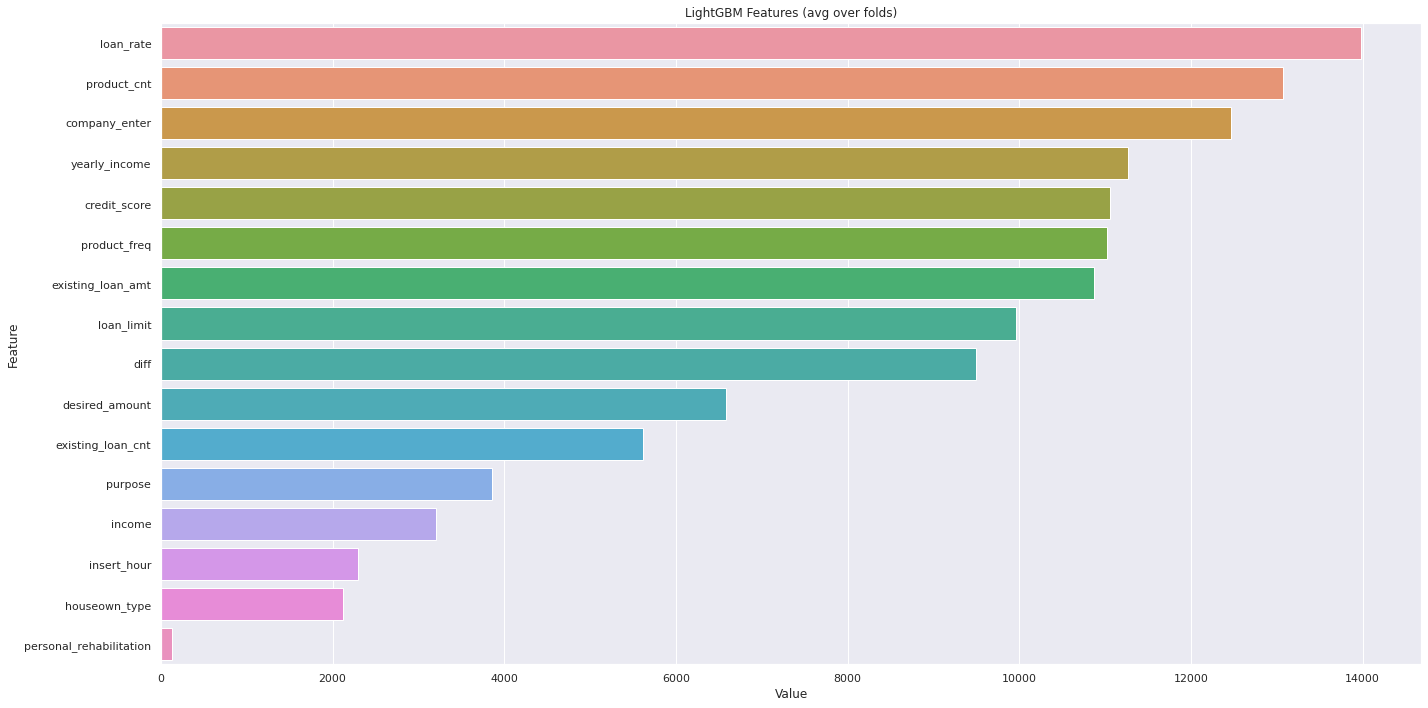

In [ ]:
#변수중요도
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid')
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## test data 예측

In [ ]:
# 전처리 완료된 데이터 불러오기
test = pd.read_csv('/content/drive/MyDrive/2022BigCon/제출파일/1014_test_final.csv')

In [ ]:
test1 = test[['application_id', 'product_id']] # 추후 데이터 병합을 위함
test.drop(columns = ['application_id', 'bank_id', 'product_id', 'user_id'], inplace = True)

In [ ]:
## test 예측하기 
X_test=test.drop(columns=['is_applied'])
y_test=test['is_applied']

test_predictions = lgb.predict(X_test)

In [ ]:
y_test=test_predictions

In [ ]:
test1['is_applied']=y_test
test1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,application_id,product_id,is_applied
0,1748340,191,0.0
1,1748340,169,0.0
2,1748340,7,0.0
3,1748340,268,1.0
4,1748340,118,0.0
...,...,...,...
3255189,1513515,263,0.0
3255190,1513515,24,0.0
3255191,1513515,204,0.0
3255192,1513515,85,0.0


In [ ]:
test_sub=pd.read_csv('/content/drive/MyDrive/2022BigCon/2022빅콘테스트_데이터분석리그_데이터분석분야_퓨처스부문_데이터셋_220908/데이터분석분야_퓨처스부문_평가데이터.csv')

In [ ]:
test_mg=pd.merge(test_sub, test1, how='left', on=['application_id','product_id'])
test_mg

,application_id,product_id,is_applied_x,is_applied_y
0,4,220,NaN,1.0
1,4,191,NaN,1.0
2,8,29,NaN,1.0
3,8,159,NaN,0.0
4,8,85,NaN,1.0
...,...,...,...,...
3255189,2167778,258,NaN,1.0
3255190,2167791,29,NaN,1.0
3255191,2167822,149,NaN,1.0
3255192,2167822,157,NaN,1.0


In [ ]:
test_mg.drop(columns=['is_applied_x'],inplace=True)
test_mg.columns=['application_id','product_id','is_applied']
test_mg

,application_id,product_id,is_applied
0,4,220,1.0
1,4,191,1.0
2,8,29,1.0
3,8,159,0.0
4,8,85,1.0
...,...,...,...
3255189,2167778,258,1.0
3255190,2167791,29,1.0
3255191,2167822,149,1.0
3255192,2167822,157,1.0


In [ ]:
test_mg.to_csv('/content/drive/MyDrive/2022BigCon/제출파일/데이터분석분야_퓨처스부문_평가데이터.csv', index = False)

In [ ]:
# 실행결과파일 저장
!jupyter nbconvert --to html "/content/drive/MyDrive/2022BigCon/제출파일/문제1_코드정리_제출용.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/2022BigCon/제출파일/문제1_코드정리_제출용.ipynb to html
[NbConvertApp] Writing 1781592 bytes to /content/drive/MyDrive/2022BigCon/제출파일/문제1_코드정리_제출용.html
